In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import RandomizedSearchCV
import keras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import  confusion_matrix

from sklearn.linear_model import LogisticRegression as lg
from sklearn.ensemble import RandomForestClassifier as rf
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import  StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
 
from sklearn.metrics import f1_score, confusion_matrix,precision_score, recall_score, accuracy_score


seed = 7  # fixing random

2025-11-27 18:11:49.323889: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-27 18:11:49.373791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 18:11:51.489995: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
data=pd.read_csv('data/The_Cancer_data_1500_V2.csv')
data.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


Exploratory Data Analysis


In [3]:
#a brief statistical summary of the data
data.describe()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,0.490667,27.513321,0.269333,0.508667,4.897929,2.417987,0.144000,0.371333
std,17.640968,0.500080,7.230012,0.443761,0.678895,2.866162,1.419318,0.351207,0.483322
min,20.000000,0.000000,15.000291,0.000000,0.000000,0.002410,0.001215,0.000000,0.000000
25%,35.000000,0.000000,21.483134,0.000000,0.000000,2.434609,1.210598,0.000000,0.000000
50%,51.000000,0.000000,27.598494,0.000000,0.000000,4.834316,2.382971,0.000000,0.000000
75%,66.000000,1.000000,33.850837,1.000000,1.000000,7.409896,3.585624,0.000000,1.000000
max,80.000000,1.000000,39.958688,1.000000,2.000000,9.994607,4.987115,1.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1500 non-null   int64  
 1   Gender            1500 non-null   int64  
 2   BMI               1500 non-null   float64
 3   Smoking           1500 non-null   int64  
 4   GeneticRisk       1500 non-null   int64  
 5   PhysicalActivity  1500 non-null   float64
 6   AlcoholIntake     1500 non-null   float64
 7   CancerHistory     1500 non-null   int64  
 8   Diagnosis         1500 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 105.6 KB


Data is clean. No missing data. 

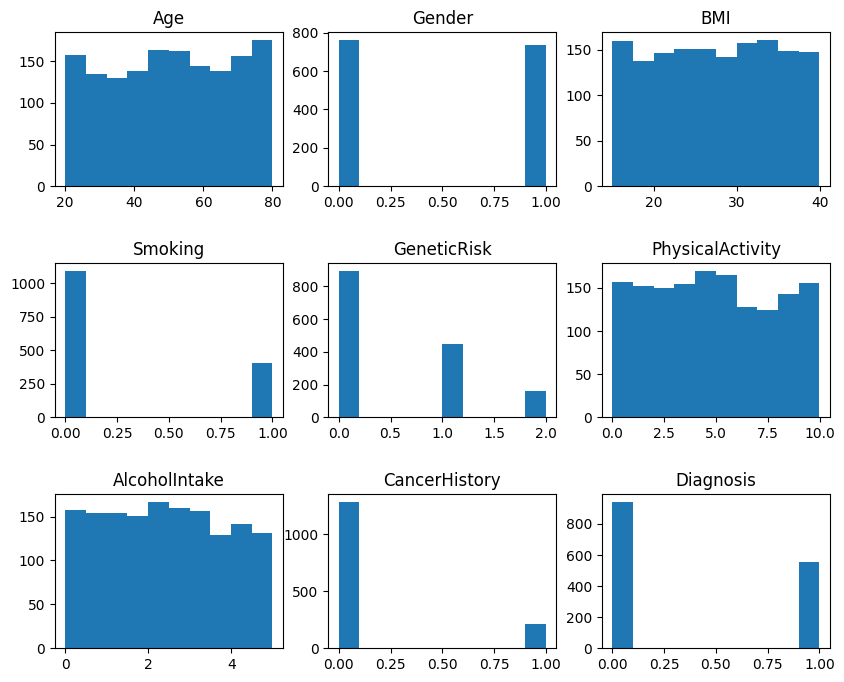

In [6]:
plt.figure(figsize=(10,8))
for i, col in enumerate(data.columns):
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(3,3, i+1)
    plt.hist(data[col])
    plt.title(col)
plt.savefig('images/data_distribution.png')

From the plots above, the data is evenly distributed and cleaned. No further preprocessing is required

Exploring how these parameters affect the ability of a patients to have cancer or not

In [7]:
data2=data.copy()
data2['Diagnosis']=data2['Diagnosis'].map({0: 'No cancer', 1:'cancer present'})
data2.head()

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,cancer present
1,71,0,30.828784,0,1,9.361630,3.519683,0,No cancer
2,48,1,38.785084,0,2,5.135179,4.728368,0,cancer present
3,34,0,30.040296,0,0,9.502792,2.044636,0,No cancer
4,62,1,35.479721,0,0,5.356890,3.309849,0,cancer present


In [20]:

import imgkit
fig= px.scatter(data2, x='AlcoholIntake', y='PhysicalActivity',
                color='Diagnosis',color_discrete_sequence=px.colors.qualitative.Alphabet, opacity=0.4)
fig.show()
fig.write_html("images/alcohol_physical_activity_scatter.html")
imgkit.from_file("images/alcohol_physical_activity_scatter.html", "images/alcohol_physical_activity_scatter.png")



QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-codespace'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

The scatter plot above shows that physical activity and alcohol intake causes cancer. However, it is not clear to what extent since there is no clear distiction on the plot.
We will investigate this further

In [21]:
fig= px.scatter_3d(data2, x='AlcoholIntake', y='PhysicalActivity', z='GeneticRisk',
                color='Diagnosis',color_discrete_sequence=px.colors.qualitative.Alphabet, opacity=0.4)
fig.show()
fig.write_html("images/alcohol_physical_activity__genetic_scatter.html")
imgkit.from_file("images/alcohol_physical_activity_scatter.html", "images/alcohol_physical_activity_genetic_scatter.png")



QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-codespace'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

From the plot above, it can be noted that people with high genetic risk are prone to cancer even if they dont take alcohol or are physically fit.
People with low genetic risk have a smaller chance of getting cancer

In [22]:
#smoking impact
data2['Smoking']=data2['Smoking'].map({0: 'No', 1:'Yes'})
fig=px.histogram(data2, x='Smoking', color='Diagnosis', barmode='group')
fig.show()
fig.write_html("images/smoking_diagnosis.html")
imgkit.from_file("images/smoking_diagnosis.html", "images/smoking_diagnosis.png")



QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-codespace'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

This indicate that the number of people who smoke and had cancer and the ones that smoke and dont have cancer are almost the same. Also, the number of people who dont smoke but has cancer is higher than the number of people who smoke and has cancer.
Hence, we cant conclude if smoking is a direct indicator of cancer

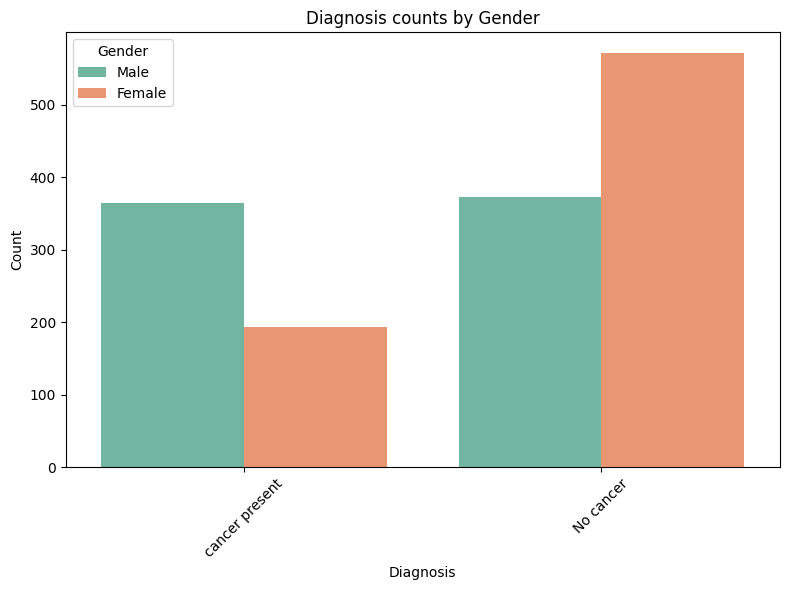

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-codespace'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [23]:
# Histogram: Diagnosis counts grouped by Gender
#smoking impact
data2['Gender']=data2['Gender'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(8,6))
sns.countplot(x='Diagnosis', hue='Gender', data=data2, palette='Set2')
plt.title('Diagnosis counts by Gender')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()
fig.write_html("images/gender_diagnosis.html")
imgkit.from_file("images/gender_diagnosis.html", "images/gender_diagnosis.png")

The plot above implies that about 1/3 of the female population has cancer while the number of male with or without cancer are equal

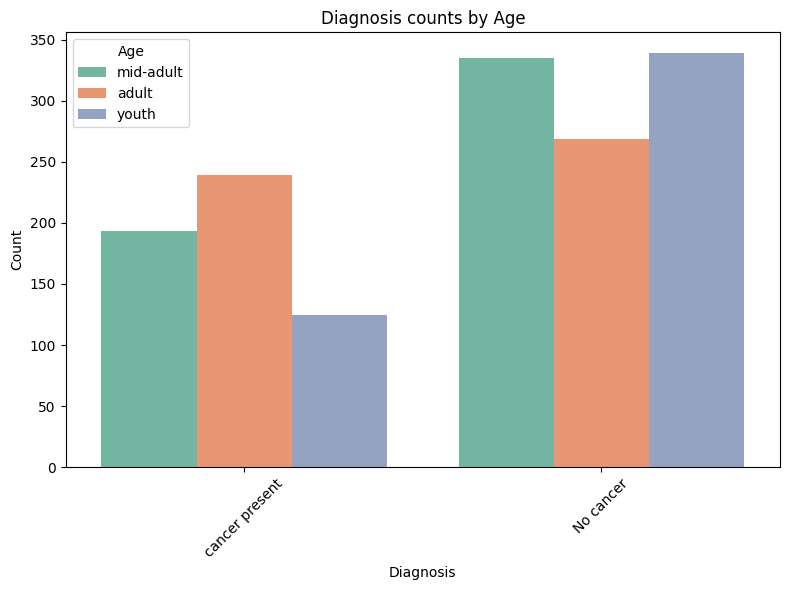

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-codespace'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [24]:
# Histogram: Diagnosis counts grouped by Age
data2["AgeGroup"] = data2["Age"].apply(
    lambda x: "youth" if 20 <= x < 40 
    else ("mid-adult" if 40 <= x < 60 
    else ("adult" if 60 <= x <= 80 
    else None))
)

plt.figure(figsize=(8,6))
sns.countplot(x='Diagnosis', hue='AgeGroup',data=data2, palette='Set2')
plt.title('Diagnosis counts by Age')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Age')
plt.tight_layout()
plt.show()
fig.write_html("images/age_diagnosis.html")
imgkit.from_file("images/age_diagnosis.html", "images/age_diagnosis.png")

Data Imputation not needed. No missing data

Model

In [25]:
#feature importance
rfc=rf()
Scaler=StandardScaler()
from sklearn.pipeline import Pipeline
pipe=Pipeline([('scaler', Scaler),
               ('classifier', rfc)
              ])
# Instantiate the SequentialFeatureSelector into a variable 'sfs'
# Re-imported class name ensures any previous kernel binding is overwritten
sfs = SequentialFeatureSelector(estimator=pipe, 
           k_features=1, 
           forward=False, 
           scoring='neg_mean_squared_error',
           )
X, y = data.drop("Diagnosis", axis = 1), data["Diagnosis"]
sfs.fit(X,y)
sfs.subsets_

{8: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7),
  'cv_scores': array([-0.04333333, -0.04333333, -0.06666667, -0.03666667, -0.2       ]),
  'avg_score': np.float64(-0.078),
  'feature_names': ('Age',
   'Gender',
   'BMI',
   'Smoking',
   'GeneticRisk',
   'PhysicalActivity',
   'AlcoholIntake',
   'CancerHistory')},
 7: {'feature_idx': (0, 1, 2, 3, 4, 6, 7),
  'cv_scores': array([-0.08      , -0.11333333, -0.06666667, -0.06333333, -0.22666667]),
  'avg_score': np.float64(-0.11000000000000001),
  'feature_names': ('Age',
   'Gender',
   'BMI',
   'Smoking',
   'GeneticRisk',
   'AlcoholIntake',
   'CancerHistory')},
 6: {'feature_idx': (0, 1, 2, 4, 6, 7),
  'cv_scores': array([-0.11      , -0.14      , -0.16      , -0.12333333, -0.25      ]),
  'avg_score': np.float64(-0.15666666666666668),
  'feature_names': ('Age',
   'Gender',
   'BMI',
   'GeneticRisk',
   'AlcoholIntake',
   'CancerHistory')},
 5: {'feature_idx': (1, 2, 4, 6, 7),
  'cv_scores': array([-0.15666667, -0.19666667, -0.17

Transformation

In [26]:
Scaler=StandardScaler()
#transforming my data
Scaler_transform=Scaler.fit_transform(X)

In [27]:
data.columns

Index(['Age', 'Gender', 'BMI', 'Smoking', 'GeneticRisk', 'PhysicalActivity',
       'AlcoholIntake', 'CancerHistory', 'Diagnosis'],
      dtype='object')

In [28]:
scale_result=np.vstack((X.mean(axis=0), X.var(axis=0),Scaler_transform.mean(axis=0), Scaler_transform.var(axis=0) )).T
#creating a dict
this_dict={'feature_names': ['Age','Gender','BMI','Smoking',
                             'GeneticRisk','PhysicalActivity',
                             'AlcoholIntake',
                    'CancerHistory']}
feature_names=this_dict['feature_names']
columns=['unscaled_mean', 'unscaled_variance',    'scaled_mean', 'scaled_variance']
df=pd.DataFrame(scale_result, index=feature_names, columns=columns)
df


,unscaled_mean,unscaled_variance,scaled_mean,scaled_variance
Age,50.320000,311.203736,-9.473903e-18,1.0
Gender,0.490667,0.250080,2.368476e-17,1.0
BMI,27.513321,52.273074,-1.184238e-17,1.0
Smoking,0.269333,0.196924,7.579123e-17,1.0
GeneticRisk,0.508667,0.460899,-8.230453e-17,1.0
PhysicalActivity,4.897929,8.214885,-1.065814e-16,1.0
AlcoholIntake,2.417987,2.014463,-1.042129e-16,1.0
CancerHistory,0.144000,0.123346,-2.131628e-17,1.0


In [29]:
#constructing my pipeline
rfc=rf()
lr=lg()
Scaler=StandardScaler()

# Combine LogisticRegression and RandomForest in a VotingClassifier
voting = VotingClassifier(estimators=[('lr', lr), ('rf', rfc)], voting='soft')
pipe = Pipeline([('scaler', Scaler), ('classifier', voting)])

#split data into test and train
X, y = data.drop("Diagnosis", axis = 1), data["Diagnosis"]

#using stratified method to split the data into 80% train and 20% test

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,
                                                random_state=42,stratify=y)  

#using stratified method to split the train_data into 80% train and 20% test
Xtrain1, Xval, ytrain1, yval = train_test_split(Xtrain, ytrain, test_size=0.2,
                                                random_state=42,stratify=ytrain)  

In [30]:
#using pipeline to fit my data
pipe_fit=pipe.fit(Xtrain1,ytrain1)
pipe_predict=pipe_fit.predict(Xval)


In [31]:

print(f'Precision score:{precision_score(yval, pipe_predict)}')
print(f'Recall:{recall_score(yval, pipe_predict)}')
print(f'Accuracy:{accuracy_score(yval,pipe_predict)}')
print(f'f1_score: {f1_score(yval, pipe_predict)}')

Precision score:0.9176470588235294
Recall:0.8764044943820225
Accuracy:0.925
f1_score: 0.896551724137931


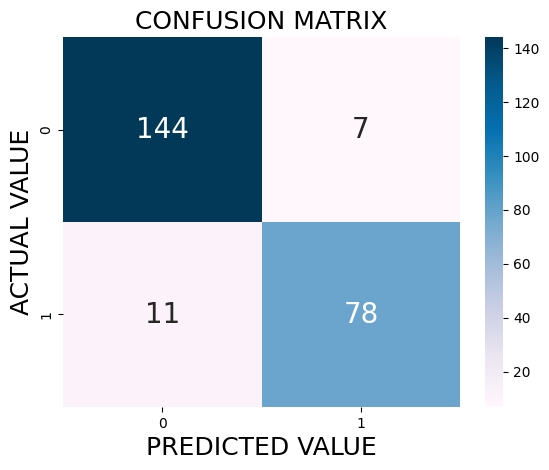

In [32]:
confusion_Matrix=confusion_matrix(yval, pipe_predict)
sns.heatmap(confusion_Matrix,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
plt.xlabel('PREDICTED VALUE', fontsize=18)
plt.ylabel('ACTUAL VALUE', fontsize=18)
plt.title('CONFUSION MATRIX', fontsize=18)
plt.savefig('images/voting_confusion_matrix.png')
    
plt.show()

## Convolutional Neural Network

In [33]:
#making Y compatible for CNN/MLP (ensure integer labels)
y = y.astype(int)
#using stratified method to split the data into 80% train and 20% test

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,
                                                random_state=42,stratify=y)  

#using stratified method to split the train_data into 80% train and 20% test
Xtrain1, Xval, ytrain1, yval = train_test_split(Xtrain, ytrain, test_size=0.2,
                                                random_state=42,stratify=ytrain)  

ytrain1 = ytrain1.astype(int)
yval = yval.astype(int)

In [34]:
def CNN(optimizer='adam', learning_rate=0.0001, decay=1e-4, epsilon=1e-4, input_dim=None):

    if input_dim is not None:
        dims = int(input_dim)
    elif 'Xtrain1' in globals() and len(Xtrain1.shape) == 2:
        dims = Xtrain1.shape[1]
    else:
        raise ValueError("Input dimension not provided and Xtrain1 not available.")

    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=dims))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision')
        ]
    )

    return model


In [35]:
#Random Search for optimal hyper-paramters
# Pass build_fn-specific args via the `model__` prefix so they are forwarded to `CNN`
Randomized_parameters={'epochs':[100, 200],
                       'model__learning_rate':[0.001,0.01],
                       'model__epsilon':[1e-4,1e-6],
                       'model__input_dim': [Xtrain1.shape[1]],  # ensure MLP input size is provided
                      'batch_size': [10,20],
                      }

Convolutional_model = KerasClassifier(build_fn=CNN, verbose=1)
Convolutional_Search=RandomizedSearchCV(estimator=Convolutional_model, cv=2, param_distributions=Randomized_parameters, verbose=1, n_iter=1,n_jobs=1)

In [36]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 30 continous epochs

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_randomized = EarlyStopping(monitor='val_loss', min_delta=0, patience=30)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

Convo_model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.weights.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq=5)

In [37]:
Convo_Randomized_model=Convolutional_Search.fit(Xtrain1, ytrain1, validation_data=(Xval, yval),verbose=1, callbacks=[early_stopping_randomized, Convo_model_checkpoint])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

2025-11-27 18:44:02.440443: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5854 - loss: 0.7692 - precision: 0.4392 - recall: 0.3591 - val_accuracy: 0.4250 - val_loss: 0.9867 - val_precision: 0.3891 - val_recall: 0.9663
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6396 - loss: 0.6666 - precision: 0.5278 - recall: 0.4199 - val_accuracy: 0.4500 - val_loss: 1.2264 - val_precision: 0.4009 - val_recall: 0.9775
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6750 - loss: 0.5958 - precision: 0.5740 - recall: 0.5359 - val_accuracy: 0.5667 - val_loss: 0.6789 - val_precision: 0.4561 - val_recall: 0.8764
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6833 - loss: 0.5801 - precision: 0.5960 - recall: 0.4972 - val_accuracy: 0.6583 - val_loss: 0.5978 - val_precision: 0.5245 - val_recall: 0.8427
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.5381 - precision: 0.6978 - recall: 0.5359 - val_accuracy: 0.5958 - val_loss: 0.8237 - val_preci

/usr/local/python/3.12.1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6062 - loss: 0.7738 - precision: 0.4532 - recall: 0.3580 - val_accuracy: 0.3917 - val_loss: 1.0150 - val_precision: 0.3755 - val_recall: 0.9663
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6167 - loss: 0.6743 - precision: 0.4692 - recall: 0.3466 - val_accuracy: 0.3750 - val_loss: 2.5148 - val_precision: 0.3724 - val_recall: 1.0000
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6979 - loss: 0.5960 - precision: 0.6202 - recall: 0.4545 - val_accuracy: 0.6208 - val_loss: 1.0291 - val_precision: 0.4500 - val_recall: 0.1011
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6750 - loss: 0.5794 - precision: 0.5685 - recall: 0.4716 - val_accuracy: 0.7125 - val_loss: 0.5846 - val_precision: 0.5833 - val_recall: 0.7865
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7167 - loss: 0.5503 - precision: 0.6538 - recall: 0.4830 - val_accuracy: 0.8042 - val_loss: 0.4818 - val_preci

/usr/local/python/3.12.1/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6187 - loss: 0.7271 - precision: 0.4850 - recall: 0.4090 - val_accuracy: 0.7167 - val_loss: 0.5895 - val_precision: 0.6296 - val_recall: 0.5730
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.6176 - precision: 0.5961 - recall: 0.4258 - val_accuracy: 0.6542 - val_loss: 0.5761 - val_precision: 1.0000 - val_recall: 0.0674
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7240 - loss: 0.5543 - precision: 0.6704 - recall: 0.5070 - val_accuracy: 0.6708 - val_loss: 0.5873 - val_precision: 1.0000 - val_recall: 0.1124
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7437 - loss: 0.5136 - precision: 0.6718 - recall: 0.6078 - val_accuracy: 0.7417 - val_loss: 0.5380 - val_precision: 0.9091 - val_recall: 0.3371
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7771 - loss: 0.4770 - precision: 0.7061 - recall: 0.6863 - val_accuracy: 0.8458 - val_loss: 0.3986 - val_precis

In [38]:
#evaluating results
print("Best: %f using %s" % (Convo_Randomized_model.best_score_, Convo_Randomized_model.best_params_))

Best: 0.821875 using {'model__learning_rate': 0.01, 'model__input_dim': 8, 'model__epsilon': 0.0001, 'epochs': 200, 'batch_size': 20}


In [39]:
means_convo =Convo_Randomized_model.cv_results_['mean_test_score']
stds_convo = Convo_Randomized_model.cv_results_['std_test_score']
params_convo = Convo_Randomized_model.cv_results_['params']
for means, stdevs, params in zip(means_convo, stds_convo, params_convo):
    print("%f (%f) with: %r" % (means, stdevs, params))

0.821875 (0.017708) with: {'model__learning_rate': 0.01, 'model__input_dim': 8, 'model__epsilon': 0.0001, 'epochs': 200, 'batch_size': 20}


In [40]:
#selecting the best model
# scikeras stores the trained Keras model in `model_` after fitting (not `model`)
Convo_model = Convo_Randomized_model.best_estimator_.model_
Convo_model

<Sequential name=sequential_2, built=True>

In [41]:
#Plotting the network model
plot_model(Convo_model, 'Cancer_ Classification.jpg', show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [42]:
#generating the convolution model statistics
results_convo = Convo_model.evaluate(Xval, yval, verbose=0)

print(f'Validation Loss: {results_convo[0]}')
print()
print(f'Validation Accuracy: {results_convo[1]}')
print()
print(f'Validation Recall: {results_convo[2]}')
print()
print(f'Validation Precision: {results_convo[3]}')
print()

# F1 Score = 2 * (precision * recall) / (precision + recall)
precision = results_convo[3]
recall = results_convo[2]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Validation F1 Score: {f1}')

Validation Loss: 0.31210198998451233

Validation Accuracy: 0.8708333373069763

Validation Recall: 0.8876404762268066

Validation Precision: 0.7900000214576721

Validation F1 Score: 0.8359788598734221


In [43]:
#estimating model accuracy
Convo_model_accuracy=Convo_model.evaluate(Xval, yval)
Convo_model_accuracy
#Predicting
Convo_pred_B = Convo_model.predict( Xval, batch_size=20, verbose=0)
pd.DataFrame(Convo_pred_B).head(10)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.3121 - precision: 0.7900 - recall: 0.8876 


,0
0,0.060737
1,0.938643
2,0.331843
3,0.951412
4,0.036621
5,0.163682
6,0.128030
7,0.951672
8,0.090635
9,0.385027


In [44]:
# Predicting — robust handling for binary (sigmoid) or multi-class outputs
Convo_pred_B = Convo_model.predict(Xval, batch_size=20, verbose=0)
preds = np.asarray(Convo_pred_B)

if preds.ndim == 2 and preds.shape[1] > 1:
    Convo_y_predict = np.argmax(preds, axis=1)
else:
    Convo_y_predict = (preds.ravel() > 0.5).astype(int)

pd.DataFrame(Convo_y_predict).head(10)

,0
0,0
1,1
2,0
3,1
4,0
5,0
6,0
7,1
8,0
9,0


In [45]:
# Prepare true labels for comparison
y_true = np.asarray(yval)

pd.DataFrame(y_true).head(10)

,0
0,0
1,1
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,0


Text(0.5, 1.0, 'CONFUSION MATRIX')

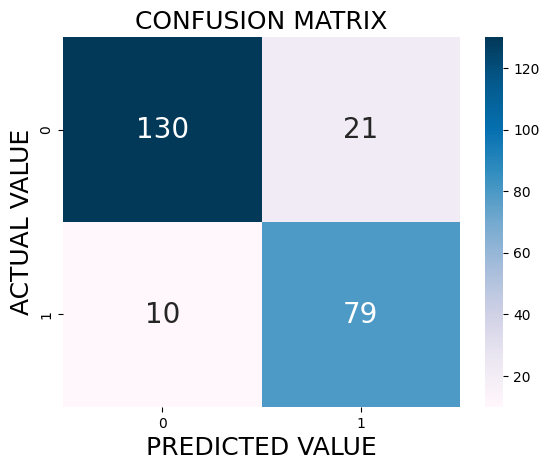

In [46]:
#Confusion matrix for BATCH NORMALIZATION

Convo_CM = confusion_matrix(y_true, Convo_y_predict)
sns.heatmap(Convo_CM,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
plt.savefig('images/batch_normalization_confusion_matrix.png')
plt.xlabel('PREDICTED VALUE', fontsize=18)
plt.ylabel('ACTUAL VALUE', fontsize=18)
plt.title('CONFUSION MATRIX', fontsize=18)

The goal of this project is to built an Cancer model predictor. Hence, I compared the convolutional neural network model with the RandomForest classifier and Logistic regression.

The CNN has an accurracy of 85% while the combination of Random Forest and Logistic regression (using the soft voting approach)has an accuracy of 93% with better recall, precision and f1 score.

The combination of Random Forest and Logistic regression (using the soft voting approach) performed better

Hence, I select the combination of Random Forest and Logistic regression as my best model to make further predictions.

## Final Model Training

In [41]:
#using pipeline to fit my data
pipe_fit=pipe.fit(Xtrain,ytrain)
pipe_predict=pipe_fit.predict(Xtest)


In [36]:
print(f'Precision score:{precision_score(ytest, pipe_predict)}')
print(f'Recall:{recall_score(ytest, pipe_predict)}')
print(f'Accuracy:{accuracy_score(ytest,pipe_predict)}')
print(f'f1_score: {f1_score(ytest, pipe_predict)}')

Precision score:0.9326923076923077
Recall:0.8738738738738738
Accuracy:0.93
f1_score: 0.9023255813953488


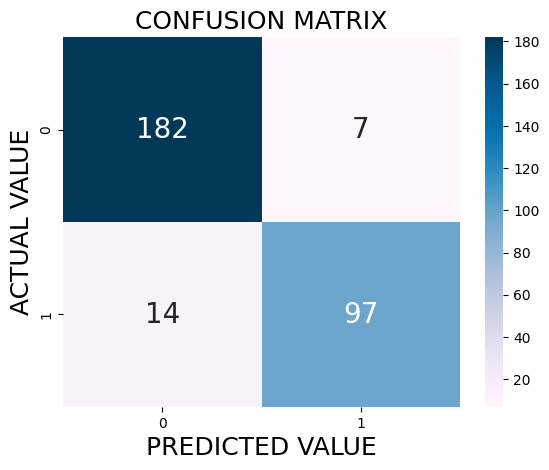

In [37]:
confusion_Matrix=confusion_matrix(ytest, pipe_predict)
sns.heatmap(confusion_Matrix,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
plt.xlabel('PREDICTED VALUE', fontsize=18)
plt.ylabel('ACTUAL VALUE', fontsize=18)
plt.title('CONFUSION MATRIX', fontsize=18)
    
plt.show()

In [45]:
#save final model
import joblib
joblib.dump(pipe, 'cancer_model.pkl')


['cancer_model.pkl']